In [1]:
#Import important libraries
import numpy as np
import pandas as pd
import seaborn as sbn
import import_ipynb
import TimeSeriesFitting as ts #Notebook with GARCH model
import fit_distribution_MLE as dist_MLE #Notebook with t-distribution related functions
import tCopula as tCopula #Notebook with tCopula functions

In [2]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
import scipy.stats.distributions as dist
import statsmodels.graphics.tsaplots as tsaplots

In [3]:
#Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Data Pre-processing

In [4]:
#Read equities and treasury yield data
amzn = pd.read_csv('AMZN.csv')
amd = pd.read_csv('AMD.csv')
nvda = pd.read_csv('NVDA.csv')
yield_hist = pd.read_csv('TreasuryYield.csv')

In [5]:
#Get the common dates/indexes between the equities
amzn_dates=pd.to_datetime(amzn['Date'])
amd_dates=pd.to_datetime(amd['Date'])
nvda_dates=pd.to_datetime(nvda['Date'])
yield_dates=pd.to_datetime(yield_hist['Date'])

In [6]:
#Get common dates between equities & treasury yields
common_idx_yield=np.intersect1d(yield_dates, amd_dates,return_indices=True)
common_idx_eq=np.intersect1d(amd_dates, yield_dates,return_indices=True)

In [7]:
yield_hist_ts=yield_hist.iloc[common_idx_yield[1],1:]
amzn_hist_ts=amzn.iloc[common_idx_eq[1],1:]
amd_hist_ts=amd.iloc[common_idx_eq[1],1:]
nvda_hist_ts=nvda.iloc[common_idx_eq[1],1:]

In [8]:
amzn_hist_ts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 0 to 250
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       250 non-null    float64
 1   High       250 non-null    float64
 2   Low        250 non-null    float64
 3   Close      250 non-null    float64
 4   Adj Close  250 non-null    float64
 5   Volume     250 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.7 KB


In [9]:
#Convert prices into log-returns
amzn_rets=np.diff(np.log(amzn_hist_ts['Adj Close']))
amd_rets=np.diff(np.log(amd_hist_ts['Adj Close']))
nvda_rets=np.diff(np.log(nvda_hist_ts['Adj Close'])) 
yield_rets=yield_hist_ts.diff()
yield_rets = yield_rets.dropna()

In [10]:
amzn_rets.shape, amd_rets.shape, yield_rets.shape

((249,), (249,), (249, 13))

In [11]:
eq_df=pd.DataFrame(data=np.array([amzn_rets, amd_rets, nvda_rets]).T, columns=['AMZN','AMD','NVDA'])

In [12]:
eq_df.head()

,AMZN,AMD,NVDA
0,-0.001075,0.016629,0.002621
1,0.001228,-0.016278,-0.002266
2,-0.015614,-0.004133,-0.005070
3,0.011002,-0.002736,0.009455
4,-0.020631,0.003616,-0.007628


In [13]:
yield_rets.reset_index(inplace=True)
yield_rets.drop(columns=['index'], inplace=True)

In [14]:
eq_yield_df=pd.concat([eq_df, yield_rets], axis=1, join='inner')

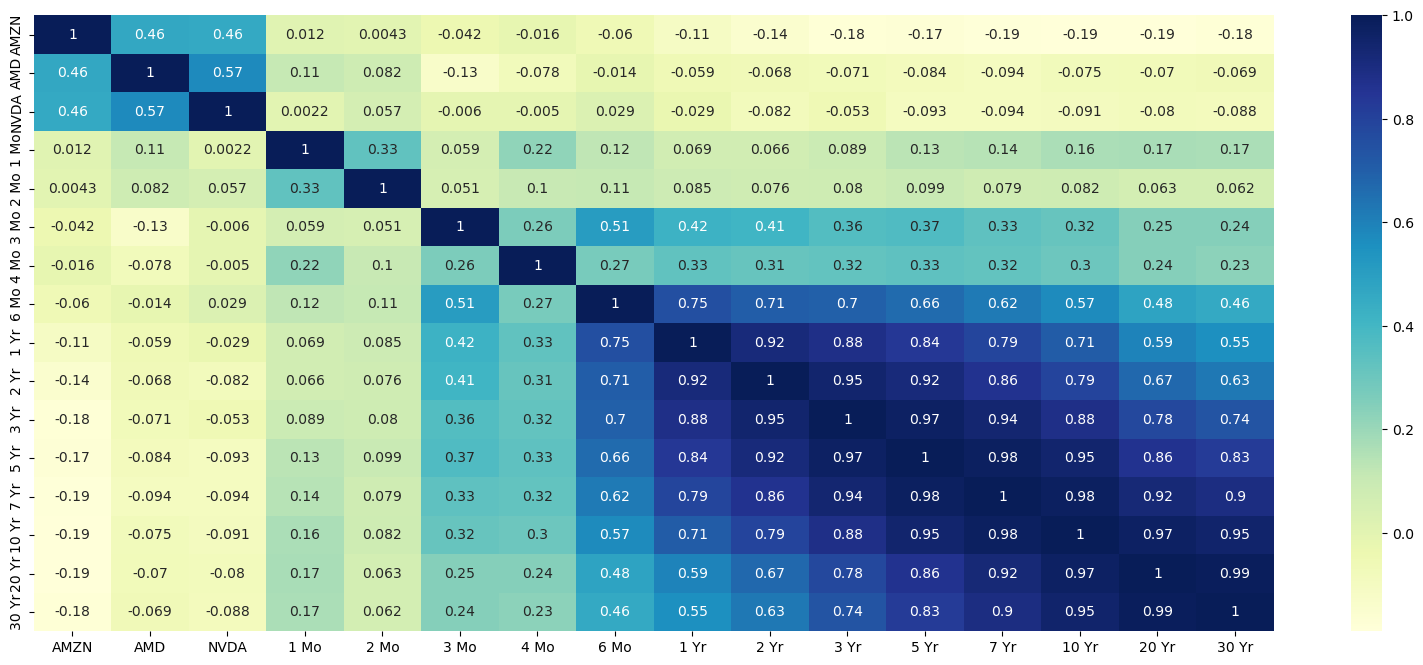

In [15]:
pyplot.figure(figsize=(20,8))
sbn.heatmap(eq_yield_df.corr(), annot=True,cmap="YlGnBu")
pyplot.show()

From the empirical data, it can be seen all 3 tech stocks exhibit negative low correlation with yield returns. Only AMZN has some significant correlation of ~-20% with longer maturity yields. 

In [16]:
#Create financial time series objects from the log-returns
amzn_ts=ts.__FinTimeSeries__(amzn_rets)
amd_ts=ts.__FinTimeSeries__(amd_rets)
nvda_ts=ts.__FinTimeSeries__(nvda_rets)

Text(0.5, 0, 'AMZN Log Returns (Lag 1)')

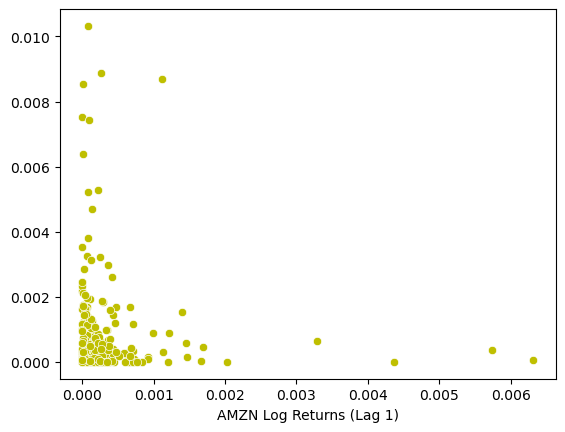

In [17]:
sbn.scatterplot(x=amzn_rets[:-1]**2, y=amd_rets[1:]**2, color='y')
pyplot.xlabel('AMZN Log Returns (Lag 1)')

# Equities time-series modeling

In [18]:
#Fit econometrics models on each series
amzn_ts.fitGARCH()
amd_ts.fitGARCH()
nvda_ts.fitGARCH()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 8643228535.020754
Iteration:      2,   Func. Count:     17,   Neg. LLF: -15.713497778752044
Iteration:      3,   Func. Count:     26,   Neg. LLF: 450.76090252729153
Iteration:      4,   Func. Count:     35,   Neg. LLF: -590.4201869107252
Iteration:      5,   Func. Count:     41,   Neg. LLF: -653.4910304230234
Iteration:      6,   Func. Count:     48,   Neg. LLF: -653.1017994452484
Iteration:      7,   Func. Count:     55,   Neg. LLF: -661.4239270258784
Iteration:      8,   Func. Count:     61,   Neg. LLF: -661.512406014212
Iteration:      9,   Func. Count:     66,   Neg. LLF: -661.5126567699307
Iteration:     10,   Func. Count:     70,   Neg. LLF: -661.5126567698826
Optimization terminated successfully    (Exit mode 0)
            Current function value: -661.5126567699307
            Iterations: 10
            Function evaluations: 70
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 820518.

In [19]:
#Get fitted parameters
amzn_params=amzn_ts.get_garch_params()
amd_params=amd_ts.get_garch_params()
nvda_params=nvda_ts.get_garch_params()

In [20]:
print(amzn_params)
print(amd_params)
print(nvda_params)

mu          0.001320
omega       0.000043
alpha[1]    0.280489
beta[1]     0.625803
Name: params, dtype: float64
mu          0.001302
omega       0.000049
alpha[1]    0.005690
beta[1]     0.937410
Name: params, dtype: float64
mu          0.005134
omega       0.000239
alpha[1]    0.149571
beta[1]     0.561529
Name: params, dtype: float64


In [21]:
pd.DataFrame(data=[amzn_params, amd_params, nvda_params], index=['AMZN','AMD','NVDA'])

,mu,omega,alpha[1],beta[1]
AMZN,0.001320,0.000043,0.280489,0.625803
AMD,0.001302,0.000049,0.005690,0.937410
NVDA,0.005134,0.000239,0.149571,0.561529


In [22]:
#Get iid residuals for each series
amzn_iid_residuals = amzn_ts.get_iid_residuals()
amd_iid_residuals=amd_ts.get_iid_residuals()
nvda_iid_residuals=nvda_ts.get_iid_residuals()

Text(0.5, 0, 'AMZN squared residuals (Lag 1)')

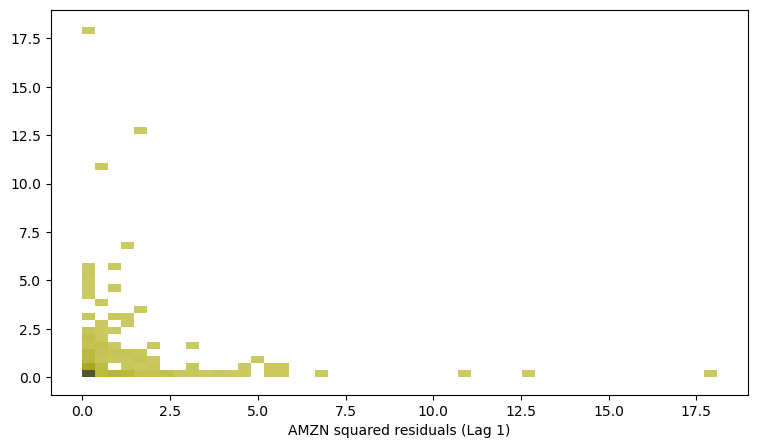

In [23]:
pyplot.figure(figsize=(9,5))
sbn.histplot(x=amzn_iid_residuals[0:-1]**2, y=amzn_iid_residuals[1:]**2, color='y')
pyplot.xlabel('AMZN squared residuals (Lag 1)')


# Treasury Yield time-series modeling

<Axes: >

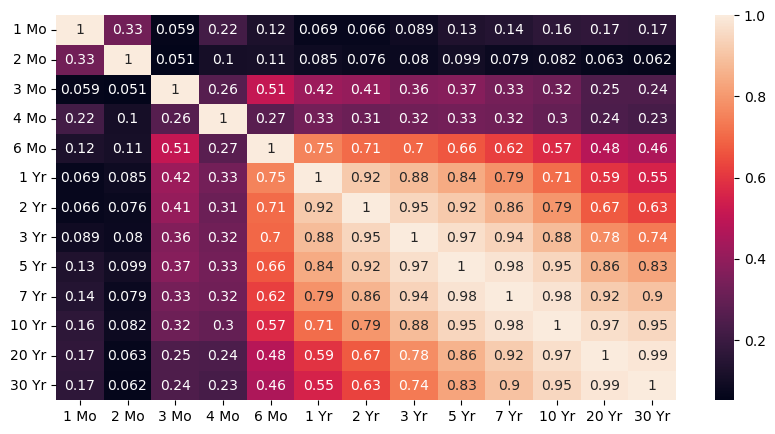

In [24]:
pyplot.figure(figsize=(10,5))
sbn.heatmap(yield_rets.corr(), annot=True)

In [25]:
#Do PCA on Yield Returns
pca_obj=PCA(n_components=3)
pca_obj.fit(yield_rets)

PCA(n_components=3)

In [26]:
#Get explained variance and principal components
print(pca_obj.explained_variance_ratio_.sum())
yield_pca_comps=pca_obj.components_

0.9564135800942323


In [27]:
#Construct time-series for first 3 PCs
first_pca_ts=yield_pca_comps[0]*yield_rets
second_pca_ts=yield_pca_comps[1]*yield_rets
third_pca_ts=yield_pca_comps[2]*yield_rets
first_pca_ts=first_pca_ts.sum(axis=1)
second_pca_ts=second_pca_ts.sum(axis=1)
third_pca_ts=third_pca_ts.sum(axis=1)

Text(0.5, 1.0, 'Third PC')

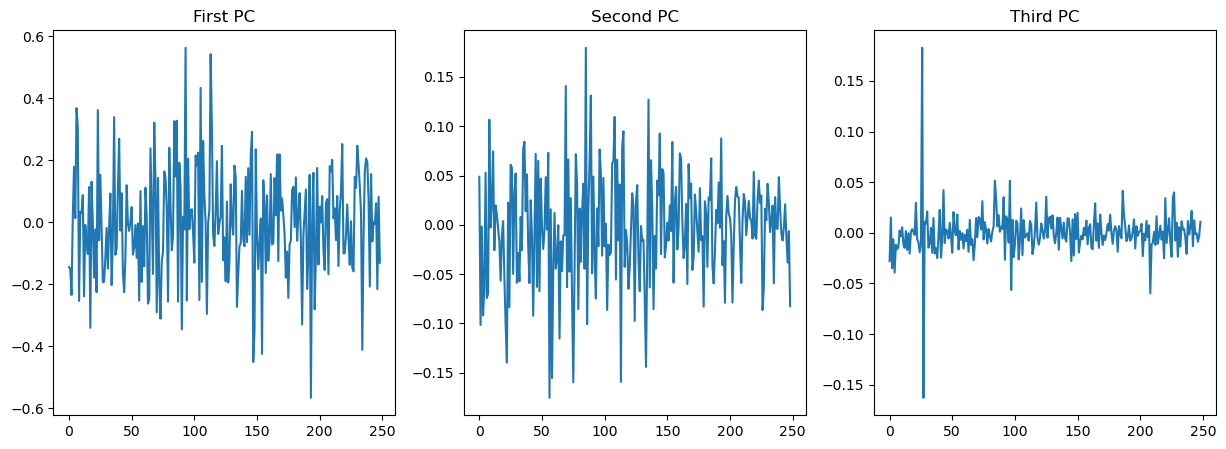

In [28]:
fig, axs=pyplot.subplots(ncols=3, figsize=(15,5))
axs[0].plot(first_pca_ts)
axs[0].set_title("First PC")
axs[1].plot(second_pca_ts)
axs[1].set_title("Second PC")
axs[2].plot(third_pca_ts)
axs[2].set_title("Third PC")

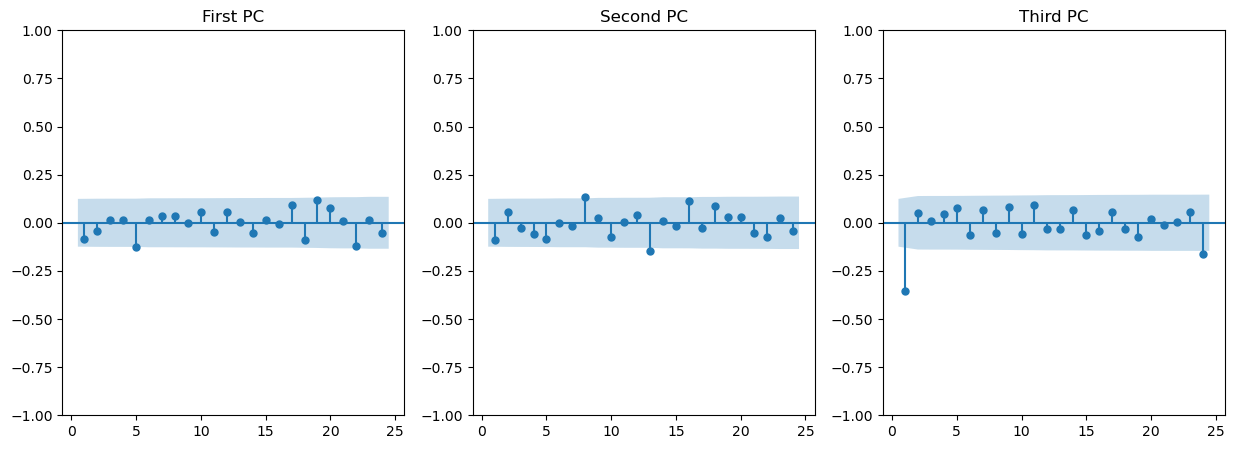

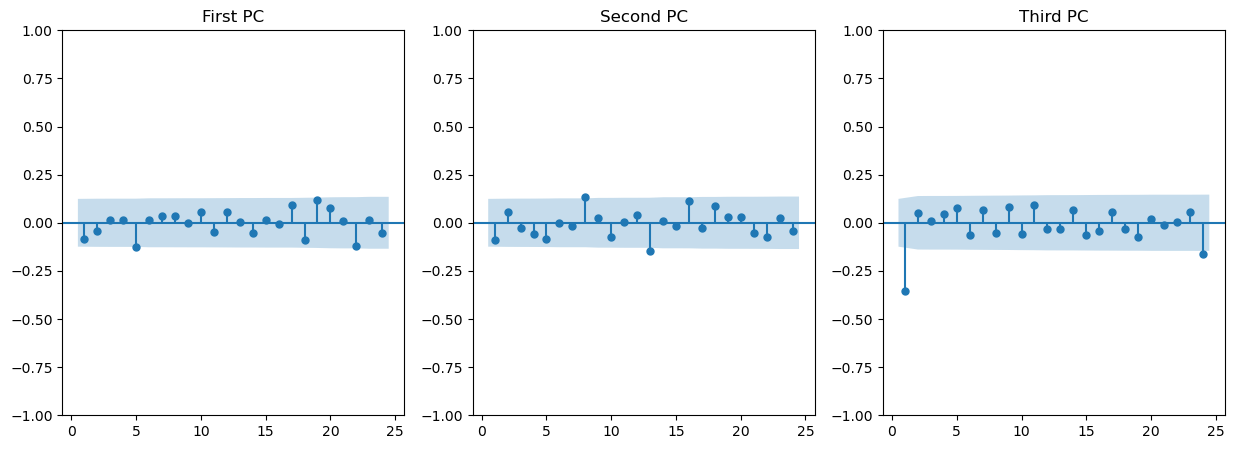

In [29]:
fig, axs=pyplot.subplots(ncols=3, figsize=(15,5))
tsaplots.plot_acf(first_pca_ts, zero=False, ax=axs[0], title='First PC')
tsaplots.plot_acf(second_pca_ts, zero=False, ax=axs[1], title='Second PC')
tsaplots.plot_acf(third_pca_ts, zero=False, ax=axs[2], title='Third PC')

In [30]:
#Fit AR(1) on third PCA
lm_model=LinearRegression()
X3=np.array(third_pca_ts[:-1]).reshape(len(third_pca_ts)-1,1)
y3=np.array(third_pca_ts[1:]).reshape(len(third_pca_ts)-1,1)
lm_model.fit(X=X3, y=y3)

LinearRegression()

In [31]:
third_pca_residuals=y3-lm_model.coef_*X3-lm_model.intercept_

In [32]:
third_pca_ts[0]-lm_model.intercept_

array([-0.02796193])

In [33]:
third_pca_residuals=third_pca_residuals.reshape(len(third_pca_residuals))

In [34]:
#third_pca_residuals[0:5]

In [35]:
third_pca_residuals_comp=np.append(third_pca_ts[0]-lm_model.intercept_,third_pca_residuals)

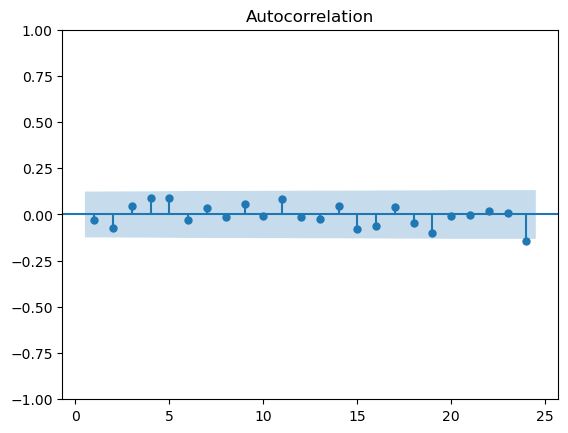

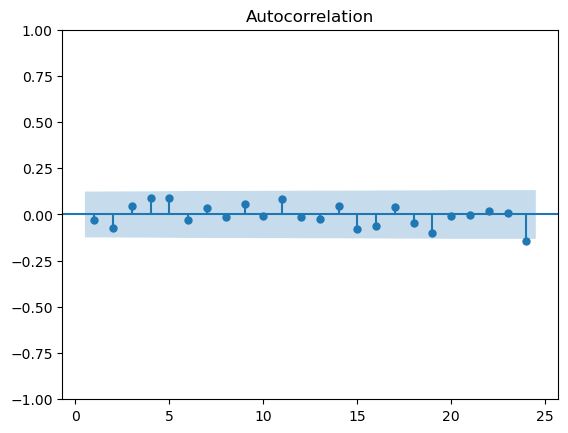

In [36]:
tsaplots.plot_acf(third_pca_residuals_comp, zero=False)

<Axes: ylabel='Count'>

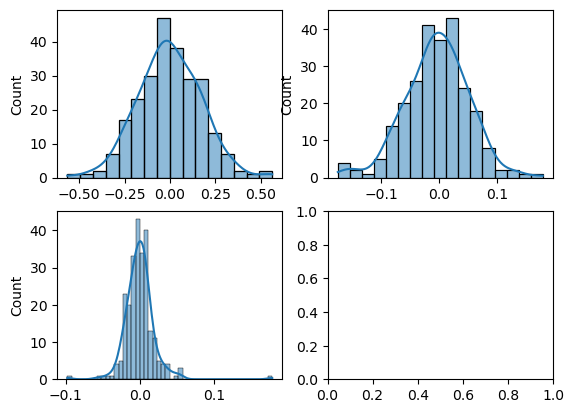

In [37]:
fig, ((ax1,ax2), (ax3, ax4))=pyplot.subplots(nrows=2, ncols=2)
sbn.histplot(first_pca_ts, kde=True, ax=ax1)
sbn.histplot(second_pca_ts, kde=True, ax=ax2)
sbn.histplot(third_pca_residuals_comp, kde=True, ax=ax3)

# Correlation & t-Copula

In [38]:
#Try fitting different distributions on iid residuals
combined_iid_residuals=np.zeros((3, len(amd_iid_residuals)))
combined_iid_residuals[0][:]=amzn_iid_residuals
combined_iid_residuals[1][:]=amd_iid_residuals
combined_iid_residuals[2][:]=nvda_iid_residuals

In [39]:
fitted_dofs=dist_MLE.fit_tdist_logMLE(combined_iid_residuals, np.arange(1,31)) 

-0.006162796102770582
0.9663285049489407
-0.003777345356336271
0.979597309282683
-0.009502961617229112
1.039024328580878


In [40]:
print(fitted_dofs)

[9. 5. 5.]


In [41]:
#Get uniform variates for equities returns
uniform_variates= dist_MLE.get_cdf_tdist(combined_iid_residuals, fitted_dofs)

In [42]:
third_pca_residuals_comp=third_pca_residuals_comp.reshape(1,len(third_pca_residuals_comp))

In [43]:
fitted_dofs_yield=dist_MLE.fit_tdist_logMLE(third_pca_residuals_comp, np.arange(1,31)) 

0.00032901639010852275
0.01836210341863922


In [44]:
uniform_variates_PCA3= dist_MLE.get_cdf_tdist(third_pca_residuals_comp, fitted_dofs_yield )

In [45]:
#Get uniform variates on Principal Components of the yields using normal distribution
uniform_variates_PCA1 = dist.norm.cdf(first_pca_ts, loc=np.mean(first_pca_ts), scale=np.std(first_pca_ts))
uniform_variates_PCA2 = dist.norm.cdf(second_pca_ts, loc=np.mean(second_pca_ts), scale=np.std(second_pca_ts))
#uniform_variates_PCA3 = dist.norm.cdf(third_pca_ts, loc=np.mean(third_pca_ts), scale=np.std(third_pca_ts))

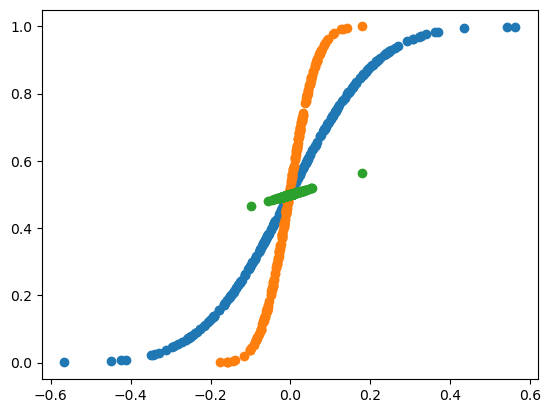

In [46]:
pyplot.scatter(x=first_pca_ts, y=uniform_variates_PCA1)
pyplot.scatter(x=second_pca_ts, y=uniform_variates_PCA2)
pyplot.scatter(x=third_pca_residuals_comp, y=uniform_variates_PCA3)

In [47]:
uniform_variates_PCA3=uniform_variates_PCA3.reshape(uniform_variates_PCA3.shape[1])

In [48]:
uniform_variates_yields=np.array([uniform_variates_PCA1, uniform_variates_PCA2, uniform_variates_PCA3])

In [49]:
uniform_variates_yields.shape

(3, 249)

In [50]:
#Get t-dist variates with dof=4 for equities and yield components
t_dof4_variates_eq=dist_MLE.get_inverse_cdf(uniform_variates)
t_dof4_variates_yields=dist_MLE.get_inverse_cdf(uniform_variates_yields)

In [51]:
#Generate correlation among the equities t-variates
corrMatrix=np.corrcoef(t_dof4_variates_eq, t_dof4_variates_yields)

In [52]:
common_df=pd.DataFrame(corrMatrix,columns=['AMZN','AMD','NVDA','PC1','PC2','PC3'],index=['AMZN','AMD','NVDA','PC1','PC2','PC3'])

In [53]:
common_df

,AMZN,AMD,NVDA,PC1,PC2,PC3
AMZN,1.000000,0.457157,0.447316,0.161072,0.071789,-0.050396
AMD,0.457157,1.000000,0.575620,0.092268,0.013210,0.039718
NVDA,0.447316,0.575620,1.000000,0.072345,0.052874,-0.050272
PC1,0.161072,0.092268,0.072345,1.000000,-0.061059,0.014176
PC2,0.071789,0.013210,0.052874,-0.061059,1.000000,0.038991
PC3,-0.050396,0.039718,-0.050272,0.014176,0.038991,1.000000


In [54]:
#Create a t-copula class with the correlation matrix
tCop = tCopula.tCopula(corrMatrix)

In [55]:
#Generate t-distribution random variates
tScenarios=tCop.generate_random_variates(num_ts=6, num_scenarios=10000)

In [56]:
tScenarios.T.shape

(6, 10000)

In [57]:
tScenarios_df=pd.DataFrame(data=tScenarios)

In [58]:
df=tScenarios_df.corr()


In [59]:
df.columns=['AMZN','AMD','NVDA','PC1','PC2','PC3']
df.index=['AMZN','AMD','NVDA','PC1','PC2','PC3']

In [60]:
df

,AMZN,AMD,NVDA,PC1,PC2,PC3
AMZN,1.000000,0.443057,0.426480,0.152953,0.061036,-0.056524
AMD,0.443057,1.000000,0.568232,0.080705,0.021992,0.052051
NVDA,0.426480,0.568232,1.000000,0.060144,0.072294,-0.023342
PC1,0.152953,0.080705,0.060144,1.000000,-0.062680,-0.005124
PC2,0.061036,0.021992,0.072294,-0.062680,1.000000,0.046126
PC3,-0.056524,0.052051,-0.023342,-0.005124,0.046126,1.000000


# Generate equity and yield price scenarios

In [61]:
#Generate equities log return scenarios based on iid residual scenarios
def generate_return_scenarios(garch_params, random_variates, last_vol, last_epsilon):
     next_cond_vol = np.sqrt(garch_params[1] + garch_params[2]*(last_epsilon**2) + garch_params[3]*(last_vol**2)) 
     next_epsilon_scenarios = next_cond_vol*random_variates
     next_ret_scenarios = garch_params[0]+ next_epsilon_scenarios
     return next_ret_scenarios   


In [62]:
#Get last conditional vol and epsilon/main residuals
amzn_cond_vols = amzn_ts.get_conditional_vol()
amd_cond_vols = amd_ts.get_conditional_vol()
nvda_cond_vols = nvda_ts.get_conditional_vol()

In [63]:
amzn_last_epsilon=amzn_rets[-1]-amzn_params[0]
amzn_ret_scenarios = generate_return_scenarios(amzn_params, tScenarios.T[0][:],amzn_cond_vols[-1],amzn_last_epsilon)

In [64]:
amd_last_epsilon=amd_rets[-1]-amd_params[0]
amd_ret_scenarios = generate_return_scenarios(amd_params, tScenarios.T[1][:],amd_cond_vols[-1],amd_last_epsilon)

In [65]:
nvda_last_epsilon=nvda_rets[-1]-nvda_params[0]
nvda_ret_scenarios = generate_return_scenarios(nvda_params, tScenarios.T[2][:],nvda_cond_vols[-1],amd_last_epsilon)

In [66]:
tScenarios.shape

(10000, 6)

In [67]:
current_third_pca=third_pca_ts[len(third_pca_ts)-1]

In [68]:
#Generate 3rd PC component scenarios using AR(1)
third_pca_scenarios=lm_model.intercept_ + (lm_model.coef_*current_third_pca) + tScenarios.T[5][:]

In [69]:
sample_arr=np.array([5,6,7])

In [70]:
third_pca_scenarios.shape

(1, 10000)

In [71]:
first_pca_scenarios=tScenarios.T[3][:].reshape(10000)
second_pca_scenarios=tScenarios.T[4][:].reshape(10000)
third_pca_scenarios=third_pca_scenarios.reshape(10000)

In [72]:
yield_pca_scenarios= np.array([first_pca_scenarios, second_pca_scenarios, third_pca_scenarios])

In [73]:
yield_pca_scenarios.shape

(3, 10000)

In [74]:
#Recover yield curve scenarios from principal components
yield_return_scenarios = np.dot(yield_pca_comps.T, yield_pca_scenarios)

In [75]:
yield_return_scenarios.shape

(13, 10000)

In [76]:
current_yield_values=np.array(yield_hist_ts.iloc[-1,:]).reshape(13,1)

In [77]:
#Generate yield/price values from yield return sceanrios
yield_value_scenarios=pd.DataFrame(data=(current_yield_values + yield_return_scenarios).T)

In [78]:
yield_value_scenarios.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,5.472068,5.482737,5.527099,5.520531,5.428521,5.307897,5.043001,4.802088,4.541319,4.462244,4.403987,4.549899,4.423191
1,5.909549,5.754397,5.779136,6.777364,5.500673,5.034007,4.063368,3.567527,3.268844,3.072560,3.013216,3.107012,3.019655
2,6.246970,5.992598,6.284810,7.969004,6.421149,6.861438,6.887632,6.453426,6.072883,5.591920,5.061141,4.521428,4.262323
3,5.354451,5.413161,5.463264,5.199076,5.407431,5.372291,5.269879,5.063103,4.784917,4.713517,4.641534,4.786969,4.648383
4,4.803141,5.076418,5.050948,3.610673,4.995181,4.935692,5.037982,4.899830,4.560865,4.597407,4.632594,4.991812,4.870893


In [79]:
#Price a treasury bond based on the yield scenarios
#Consider a bond with 2-year maturity, coupon frequency of 4 (every 3 months) and a coupon rate of 3.75%
timesToPayments = np.arange(0.25,2.25, 0.25)
coupon_rate=0.0375
yield_maturities=yield_rets.columns.tolist()
yield_maturities_yr=[float(mat.split()[0])/12 if mat.split()[1]=='Mo' else  int(mat.split()[0]) for mat in yield_maturities ]
current_yields_arr=current_yield_values.reshape(len(current_yield_values))
yields_interpolated=np.interp(timesToPayments, xp=np.array(yield_maturities_yr), fp=current_yields_arr)

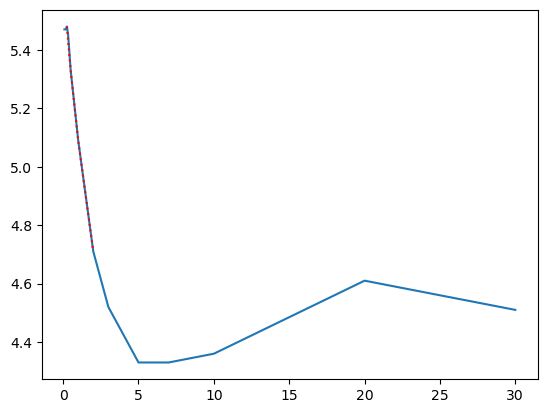

In [80]:
#Plot the interpolated yields to market data
pyplot.plot(np.array(yield_maturities_yr), current_yields_arr)
pyplot.plot(timesToPayments, yields_interpolated, color='r', linestyle='dotted')

In [107]:
#Price bond - current value and scenario values
bond_curr_values=[(coupon_rate*0.25)/(1+y*mat*0.01) if mat < 1 else (coupon_rate*0.25)/(1+y*0.01)**mat for y, mat in zip(yields_interpolated, timesToPayments)]
bond_curr_val=sum(bond_curr_values[:-1])+ bond_curr_values[-1] + 1/(1+yields_interpolated[-1])**timesToPayments[-1]

In [115]:
yield_value_scenarios.shape[0]

10000

In [119]:
#Price bond for each of theabs stScenarios
bond_scenario
for count in np.arange(0,5):
    #Get interpolated yields
    yields_scenario_interpolated=np.interp(timesToPayments, xp=np.array(yield_maturities_yr), fp=np.array(yield_value_scenarios.T[count][:]))
    bond_scenario_values=[(coupon_rate*0.25)/(1+y*mat*0.01) if mat < 1 else (coupon_rate*0.25)/(1+y*0.01)**mat for y, mat in zip(yields_interpolated, timesToPayments)]
    bond_scenario_val=sum(bond_curr_values[:-1])+ bond_curr_values[-1] + 1/(1+yields_interpolated[-1])**timesToPayments[-1]

[5.52709937 5.42852055 5.36820857 5.30789659 5.24167278 5.17544898
 5.10922517 5.04300136]
[5.7791362  5.50067279 5.26734004 5.03400728 4.7913475  4.54868773
 4.30602795 4.06336818]
[6.28481021 6.42114915 6.64129372 6.86143829 6.86798681 6.87453533
 6.88108385 6.88763237]
[5.46326362 5.40743087 5.38986071 5.37229055 5.34668776 5.32108497
 5.29548219 5.2698794 ]
[5.05094838 4.99518114 4.96543638 4.93569162 4.96126424 4.98683685
 5.01240947 5.03798208]


# Simple Portfolio Construction

In [ ]:
#Create portfolio scenarios
#100 long AMZN, 100 long AMD, -100 short NVDA
combined_port_scenarios =-100*amzn_ret_scenarios+200*amd_ret_scenarios-100*nvda_ret_scenarios

In [ ]:
sbn.histplot(combined_port_scenarios, kde=True)

In [ ]:
np.quantile(combined_port_scenarios, 0.01)